Notebook to Investigate Base Run's Baroclinic Properties

In [528]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as NC
import pandas as pd

from scipy.optimize import curve_fit
from salishsea_tools import ellipse
from salishsea_tools import viz_tools
from salishsea_tools import tidetools
from nowcast import analyze

from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable

(1920, 1, 1)


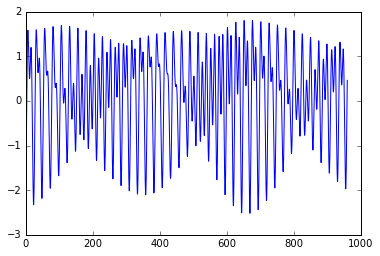

In [502]:
name = 'GmO_TS13'
if name == 'GmO_Base':
    timeinc = 3659558400
elif name == 'GmO_TS13':
    timeinc = 3259872000
fT1 = NC.Dataset('../../myResults/NEMO36_Tides/'+name+'/PointAtkinson.nc','r')
ssh = fT1.variables['sossheig'][:]
time = (fT1.variables["time_counter"][:]-timeinc)/3600. 
print (ssh.shape)
plt.plot(time,ssh[:,0,0])

In [503]:
uv = NC.Dataset('../../myResults/NEMO36_Tides/'+name+'/CODAR.nc')
ugrid = uv.variables['vozocrtx']
vgrid = uv.variables['vomecrty']
depths = uv.variables['deptht']
u, v = viz_tools.unstagger(ugrid, vgrid)
lat = uv.variables['nav_lat']
lon = uv.variables['nav_lon']

So initially, I had x-values starting at 241 in Fortran, 240 in Python.  However by averaging, I lose the 240 value and am starting at 241. Similarly in y I should be starting at 381.  I'm not sure however, what the lats and lons I'm getting from the CODAR file are.  Lets take a look at that compared to the bathymetry file.

In [4]:
bathyset = NC.Dataset('../../NEMO-forcing/grid/bathy_downonegrid.nc')
bathy_lat = bathyset['nav_lat']
bathy_lon = bathyset['nav_lon']

And according to research_VENUS, the VENUS east point is at 416, 283 == 49.0419, -123.3176

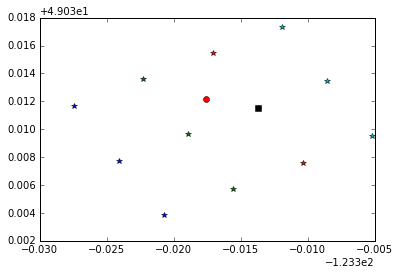

In [5]:
plt.plot(bathy_lon[415:418,281:285], bathy_lat[415:418, 281:285],'*')
plt.plot(bathy_lon[416, 283], bathy_lat[416, 283], 'ks')
plt.plot(-123.3176, 49.0422, 'ro')

Okay, lets go back to the source.  According to: http://venus.uvic.ca/locations/instrument_tables.php#SOGSHALLOW East is at 49 2.531, -123 19.059

In [6]:
east_lat = 49+2.531/60.
east_lon = -(123 + 19.059/60.)

print (east_lat, east_lon)

49.042183333333334 -123.31765


In [7]:
for i in [416,417]:
    for j in [282,283]:
        print (i, j, tidetools.haversine(east_lon, east_lat, bathy_lon[i,j], bathy_lat[i,j]))

416 282 0.2969988994434936
416 283 0.2939856215868898
417 282 0.37109625902852533
417 283 0.36725074117185247


In [8]:
print (lat[0,0], lon[0,0], bathy_lat[380, 240], bathy_lon[380, 240])

48.8182 -123.417 48.8181686401 -123.416664124


Okay, this is what I expected.  The u,v files, however are now starting at 381, 241.  So 416, 283 is 35, 42

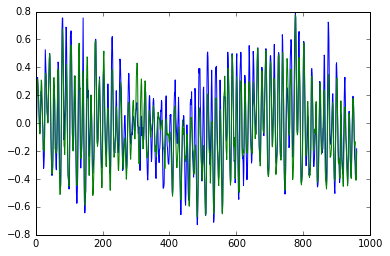

In [114]:
ieast = 35; jeast = 42
icent = 43; jcent = 25
cent_lat = 49.0401; cent_lon = -123.4261
plt.plot(v[:, 0, ieast, jeast])
plt.plot(v[:, 5, ieast, jeast])

In [32]:
print (np.mean(v[:, 0, ieast, jeast]), np.mean(v[:, 5, ieast, jeast]))

-0.18078 -0.108047


In [11]:
# function for fitting 6 frequencies and inferring 2 with constant
def sixplustwo(xplus, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha, S2amp, S2pha,
                 N2amp, N2pha, Q1amp, Q1pha, Constant):
    x = xplus[0]

    P1K1amp = xplus[1]
    P1K1pha = xplus[2]
    K2S2amp = xplus[3]
    K2S2pha = xplus[4]
    
    return (M2amp * M2ft * np.cos(M2freq*x - (M2pha - M2uvt) *np.pi/180.) +
             K1amp * K1ft * np.cos(K1freq*x - (K1pha - K1uvt) *np.pi/180.) +
             O1amp * O1ft * np.cos(O1freq*x - (O1pha - O1uvt) *np.pi/180.) +
             S2amp * S2ft * np.cos(S2freq*x - (S2pha - S2uvt) *np.pi/180.) +
             P1K1amp * K1amp *P1ft * np.cos(P1freq*x - (K1pha + P1K1pha - P1uvt) *np.pi/180.) +
             N2amp * N2ft * np.cos(N2freq*x - (N2pha - N2uvt) *np.pi/180.) +
             Q1amp * Q1ft * np.cos(Q1freq*x - (Q1pha - Q1uvt) *np.pi/180.) +
             K2S2amp * S2amp *K2ft * np.cos(K2freq*x - (S2pha + K2S2pha - K2uvt) *np.pi/180.) + Constant )

In [505]:
M2freq = 28.984106 # degrees per hour
M2freq = M2freq*np.pi/180. # radians per hour
#K1
K1freq = 15.041069*np.pi/180.
#O1
O1freq = 13.943036*np.pi/180.
#S2
S2freq = 30.000002*np.pi/180.
#P1
P1freq = 14.958932*np.pi/180.
#N2
N2freq = 28.439730*np.pi/180.
#Q1
Q1freq = 13.398661*np.pi/180.
#K2
K2freq = 30.082138*np.pi/180.

# initial phase calculation
# for Dec 20, 2015
# data for phase output from sbctides.F90; found in ocean.output
K1ft = 0.882044509440140
K1uvt = 180./np.pi*(-0.01198932264051458+1.198932264051458)
M2ft = 1.03774639446235
M2uvt = 180./np.pi*(-12.5687951531251+15.0747977989126)
# Not using here so set to 1/0
if name=='GmO_TS13':
    K1ft = 1.065505
    K1uvt =  111.481741
    M2ft = 0.982328
    M2uvt =  250.506179
O1ft = 1.
O1uvt = 0.
S2ft = 1.0
S2uvt = 0.0
P1ft = 1.0
P1uvt = 0.0
N2ft = 1.0
N2uvt = 0.0
Q1ft = 1.0
Q1uvt = 0.0
K2ft = 1.0
K2uvt = 0.0

In [516]:
sCO = 79
#iichoice = [10, 20, 30, 40, 50, 60, 70]; jjchoice = [10, 20, 30, 40, 50, 60, 70]
iichoice = [ieast, icent]; jjchoice= [jeast,jcent]
ddchoice = range(40)

In [507]:
timeplus = np.zeros([5,960])
P1K1_amp = 0.31; P1K1_pha = -3
K2S2_amp = 0.27; K2S2_pha = 0
v_M2pha = np.zeros((sCO, sCO, 40)); v_M2amp = np.zeros((sCO, sCO, 40))
u_M2amp = np.zeros((sCO, sCO, 40)); u_M2pha = np.zeros((sCO, sCO, 40))
print (time[0:-1:2].shape)
timeplus[0] = time[0:-1:2]
timeplus[1] = P1K1_amp*np.ones_like(timeplus[0]); timeplus[2] = P1K1_pha*np.ones_like(timeplus[0])
timeplus[3] = K2S2_amp*np.ones_like(timeplus[0]); timeplus[4] = K2S2_pha*np.ones_like(timeplus[0])

(960,)


In [115]:
vavg = np.zeros((960, sCO, sCO))
vavg_M2amp = np.zeros((sCO, sCO)); vavg_M2pha = np.zeros((sCO, sCO))
for ii in iichoice:
    for jj in jjchoice:
        m = v[:,:,ii,jj] == 0
        v_masked = np.ma.array(v[:,:,ii,jj], mask=m)
        vavg[:,ii,jj] = analyze.depth_average(v_masked, depths, depth_axis=1)
        fitted, cov = curve_fit(sixplustwo, timeplus, vavg[:,ii,jj]) 
        vavg_M2amp[ii,jj] = fitted[0]
        vavg_M2pha[ii,jj] = fitted[1]

/home/sallen/anaconda/envs/nowcast-dev/lib/python3.5/site-packages/scipy/optimize/minpack.py:601: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [116]:
uavg = np.zeros((960, sCO, sCO))
uavg_M2amp = np.zeros((sCO, sCO)); uavg_M2pha = np.zeros((sCO, sCO))
for ii in iichoice:
    for jj in jjchoice:
        m = u[:,:,ii,jj] == 0
        u_masked = np.ma.array(u[:,:,ii,jj], mask=m)
        uavg[:,ii,jj] = analyze.depth_average(u_masked, depths, depth_axis=1)
        fitted, cov = curve_fit(sixplustwo, timeplus, uavg[:,ii,jj]) 
        uavg_M2amp[ii,jj] = fitted[0]
        uavg_M2pha[ii,jj] = fitted[1]

/home/sallen/anaconda/envs/nowcast-dev/lib/python3.5/site-packages/scipy/optimize/minpack.py:601: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [517]:
for ii in iichoice:
    print (ii)
    for jj in jjchoice:
        for i in ddchoice:
            if np.abs(v[5,i,ii,jj]) > 0.00000001:
                fitted, cov = curve_fit(sixplustwo, timeplus, v[:,i,ii,jj]) 
                v_M2amp[ii,jj,i] = fitted[0]
                v_M2pha[ii,jj,i] = fitted[1]

35
43


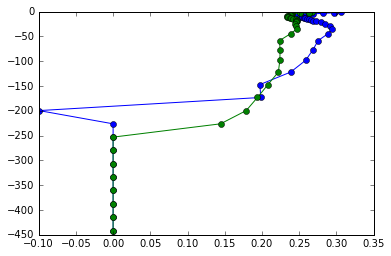

In [18]:
plt.plot(v_M2amp[ieast, jeast], -depths[:],'o-')
plt.plot(v_M2amp[ieast, jeast-5], -depths[:],'o-')

In [518]:
for ii in iichoice:
    print (ii)
    for jj in jjchoice:
        for i in ddchoice:
            if np.abs(u[8,i,ii,jj]) > 0.00000001:
                fitted, cov = curve_fit(sixplustwo, timeplus, u[:,i,ii,jj]) 
                u_M2amp[ii,jj,i] = fitted[0]
                u_M2pha[ii,jj,i] = fitted[1]

35
43


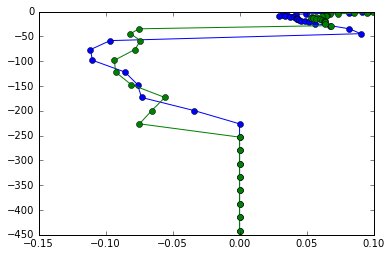

In [20]:
plt.plot(u_M2amp[ieast, jeast], -depths[:],'o-')
plt.plot(u_M2amp[ieast, jeast-5], -depths[:],'o-')

In [40]:
# observations
node = [[0.177, 0.006, 109, 311, 0.106, 0.007, 112, 188],[ 0.262, -0.005, 125, 320, 0.175, -0.011, 122, 220]]
# v1.0
soon = [[0.16, 0.013, 130, 305, 0.08, 0.005, 135, 184], [0.29, -0.017, 137, 324, 0.19, -0.025, 131, 226 ]]

In [38]:
CX, SX, CY, SY, ap, am, ep, em, major, minor, theta, phase = ellipse.ellipse_params(uavg_M2amp, uavg_M2pha, vavg_M2amp, vavg_M2pha)

(79, 79)


NameError: name 'soon' is not defined

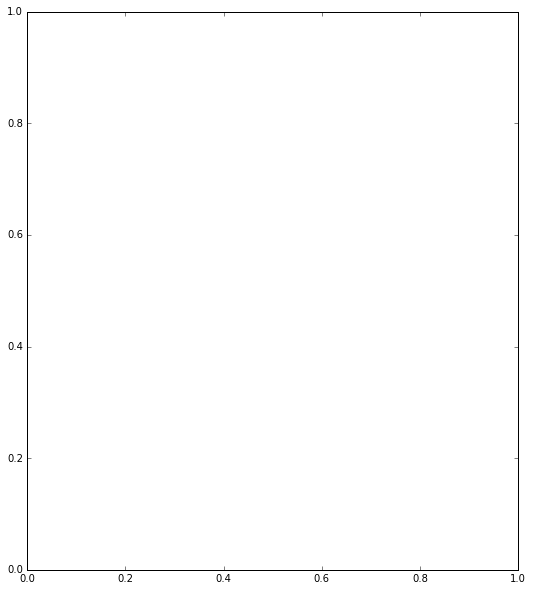

In [39]:
scale = 0.4
print (major.shape)
grid_B = '../../NEMO-forcing/grid/bathy_downonegrid.nc'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
viz_tools.set_aspect(ax) 
ii = ieast; jj = jeast; inode = 1
for ii, jj, inode in zip((ieast,icent), (jeast, jcent), (1,0)):
    ellsc = Ellipse(xy=(lon[ii,jj], lat[ii,jj]),
                width=scale * soon[inode][0],
                height=scale * soon[inode][1],
                angle= soon[inode][2],
                color='grey')
    ax.add_artist(ellsc)
    ellsc = Ellipse(xy=(lon[ii,jj], lat[ii,jj]),
                width=scale * node[inode][0],
                height=scale * node[inode][1],
                angle= node[inode][2],
                color='green')
    ax.add_artist(ellsc)
    ellsc = Ellipse(xy=(lon[ii,jj], lat[ii,jj]),
                width=scale * major[ii,jj],
                height=scale * minor[ii,jj],
                angle=theta[ii,jj]+29,
                color='red')
   
    ax.add_artist(ellsc)
viz_tools.plot_land_mask(ax, grid_B, coords='map')
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=5)
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=10)
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=20)

ax.set_xlim(-123.7, -123.)
ax.set_xticks((-123.6, -123.4, -123.2, -123.))
ax.set_xticklabels(('-123.6', '-123.4', '-123.2', '-123.'))
ax.set_yticks((48.9, 49, 49.1, 49.2, 49.3))
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Latitude", fontsize=20)

ax.set_ylim(48.89, 49.3)
ellsc = Ellipse(xy=(-123.13, 49.2),
                width=scale * 0.05,
                height=scale * 0.2,
                angle=29.,
                color='grey')
   
ax.add_artist(ellsc)
ax.text(-123.1, 49.2,'20 cm s$^{-1}$', fontsize=14, color='grey')
ax.text(-123.65, 49.28, 'New Model', fontsize=14, color='red')
ax.text(-123.65, 49.26, 'Observations', fontsize=14, color='green')
ax.text(-123.65, 49.24, 'Production Model', fontsize=14, color='grey')
ax.text(-123.3, 48.92, 'Bathymetry: 5 m, 10 m, 20 m')
ax.set_title('Barotropic Tidal Ellipses', fontsize=20)

In [522]:
CX, SX, CY, SY, ap, am, ep, em, major, minor, theta, phase = ellipse.ellipse_params(u_M2amp, u_M2pha, v_M2amp, v_M2pha)
#CX, SX, CY, SY, ap, am, ep, em, major_avg, minor_avg, theta_avg, phase_avg = ellipse.ellipse_params(uavg_M2amp, uavg_M2pha, vavg_M2amp, vavg_M2pha)

(79, 79, 40)


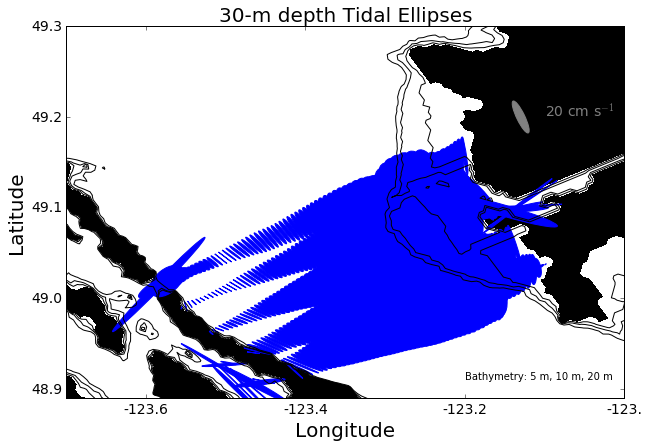

In [341]:
scale = 0.2
print (major.shape)
grid_B = '../../NEMO-forcing/grid/bathy_downonegrid.nc'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
viz_tools.set_aspect(ax) 
for ii in [20, 27, 35, 43, 50]:
    for jj in jjchoice:
        id = 0
        ellsc = Ellipse(
                xy=(lon[ii,jj], lat[ii,jj]),
                width=scale * major[ii,jj,id],
                height=scale * minor[ii,jj,id],
                angle=theta[ii,jj,id]+29,
                color='blue')
        ax.add_artist(ellsc)
        ellsc = Ellipse(
                xy=(lon[ii,jj], lat[ii,jj]),
                width=scale * major_avg[ii,jj],
                height=scale * minor_avg[ii,jj],
                angle=theta_avg[ii,jj]+29,
                color='red')
#        ax.add_artist(ellsc)
        
viz_tools.plot_land_mask(ax, grid_B, coords='map')
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=5)
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=10)
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=20)

ax.set_xlim(-123.7, -123.)
ax.set_xticks((-123.6, -123.4, -123.2, -123.))
ax.set_xticklabels(('-123.6', '-123.4', '-123.2', '-123.'))
ax.set_yticks((48.9, 49, 49.1, 49.2, 49.3))
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Latitude", fontsize=20)

ax.set_ylim(48.89, 49.3)
ellsc = Ellipse(xy=(-123.13, 49.2),
                width=scale * 0.05,
                height=scale * 0.2,
                angle=29.,
                color='grey')
   
ax.add_artist(ellsc)
ax.text(-123.1, 49.2,'20 cm s$^{-1}$', fontsize=14, color='grey')
#ax.text(-123.65, 49.28, 'Barotropic Tides', fontsize=14, color='red')
#ax.text(-123.65, 49.26, 'Surface Tides', fontsize=14, color='blue')
ax.text(-123.2, 48.91, 'Bathymetry: 5 m, 10 m, 20 m')
ax.set_title('30-m depth Tidal Ellipses', fontsize=20)

(79, 79, 40)


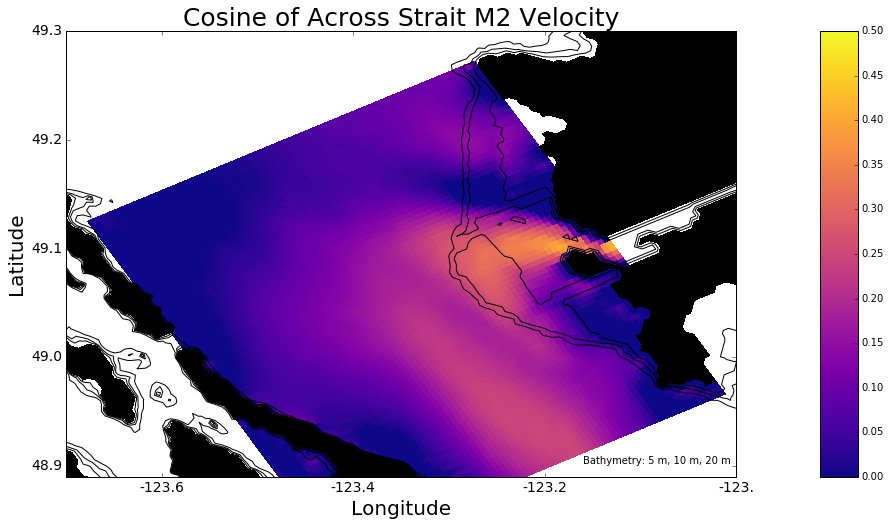

In [515]:
scale = 0.2
print (major.shape)
grid_B = '../../NEMO-forcing/grid/bathy_downonegrid.nc'
fig, ax = plt.subplots(1, 1, figsize=(15,15))
viz_tools.set_aspect(ax) 
id=0
cmap = plt.get_cmap('plasma')
cmap.set_bad('white')

mesh=ax.pcolormesh(lon[:-1,:-1], lat[:-1,:-1], CX[:,:,id], cmap=cmap, vmin=0, vmax=0.5)
        
viz_tools.plot_land_mask(ax, grid_B, coords='map')
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=5)
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=10)
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=20)

ax.set_xlim(-123.7, -123.)
ax.set_xticks((-123.6, -123.4, -123.2, -123.))
ax.set_xticklabels(('-123.6', '-123.4', '-123.2', '-123.'))
ax.set_yticks((48.9, 49, 49.1, 49.2, 49.3))
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Latitude", fontsize=20)

ax.set_ylim(48.89, 49.3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad="5%")

fig.colorbar(mesh, cax=cax)


#ax.text(-123.1, 49.2,'20 cm s$^{-1}$', fontsize=14, color='grey')
#ax.text(-123.65, 49.28, 'Barotropic Tides', fontsize=14, color='red')
#ax.text(-123.65, 49.26, 'Surface Tides', fontsize=14, color='blue')
ax.text(-123.16, 48.902, 'Bathymetry: 5 m, 10 m, 20 m')
ax.set_title('Cosine of Across Strait M2 Velocity', fontsize=25)

0.4966666666666667
0.6633333333333333
0.8300000000000001


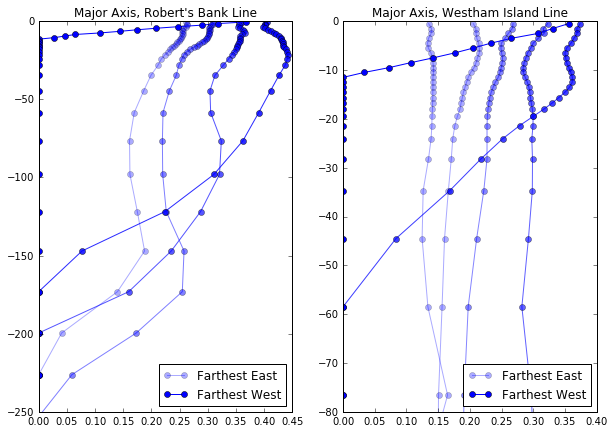

In [144]:
fig, axs = plt.subplots(1,2,figsize=(10,7))
ileft = 20
iright = 30
axs[0].plot(major[ileft, 20], -depths[:], 'o-', label="Farthest East", color='b', alpha=0.33)
for jj in [30, 40, 50]:
    print ((jj-20)/60.+0.33)
    axs[0].plot(major[ileft, jj], -depths[:], 'o-', color='b', alpha=(jj-20)/60.+0.33)
axs[0].plot(major[ileft, 60], -depths[:], 'o-', label="Farthest West", color='b', alpha=1)

axs[1].plot(major[iright, 10], -depths[:], 'o-', label="Farthest East", color='b', alpha=0.33)
for jj in [20, 30, 40, 50]:
    axs[1].plot(major[iright, jj], -depths[:], 'o-', color='b', alpha=(jj-20)/70.+0.33)
axs[1].plot(major[iright, 60], -depths[:], 'o-', label="Farthest West", color='b', alpha=1)
    

axs[0].set_ylim(-250,0)
axs[0].legend(loc='lower right')
axs[1].set_ylim(-80,0)
axs[1].legend(loc='lower right')
axs[0].set_title("Major Axis, Robert's Bank Line")
axs[1].set_title("Major Axis, Westham Island Line")

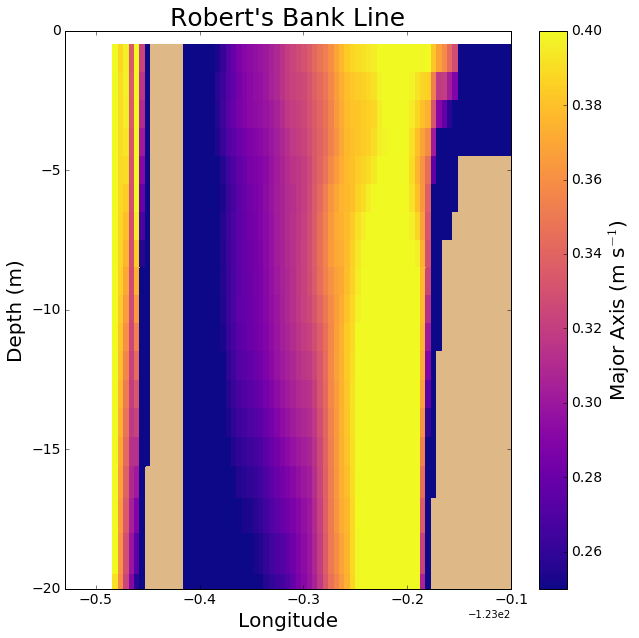

In [441]:
m = major == 0
major_masked = np.ma.array(major, mask=m)
mm = minor == 0
minor_masked = np.ma.array(minor, mask=mm)
mt = theta == 0
theta_masked = np.ma.array(theta, mask=mt)
fig, ax =plt.subplots(1,1,figsize=(10,10))
cmap = plt.get_cmap('plasma')
cmap.set_bad('burlywood')
mesh=ax.pcolormesh(lon[20], -depths[:], major_masked[20].transpose(), cmap=cmap, vmax=0.4, vmin=0.25)
ax.set_ylim((-20,0))
ax.set_xlim(-123.53, -123.1)
#ax.set_xlim(-123.45, -123.09)
#ax.set_xticks((-123.4, -123.3, -123.2, -123.1))
#ax.set_xticklabels(('-123.4','-123.3', '-123.2', '-123.1'))
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Depth (m)", fontsize=20)
cbar = fig.colorbar(mesh)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Major Axis (m s$^{-1}$)", fontsize=20)
ax.set_title("Robert's Bank Line", fontsize=25)

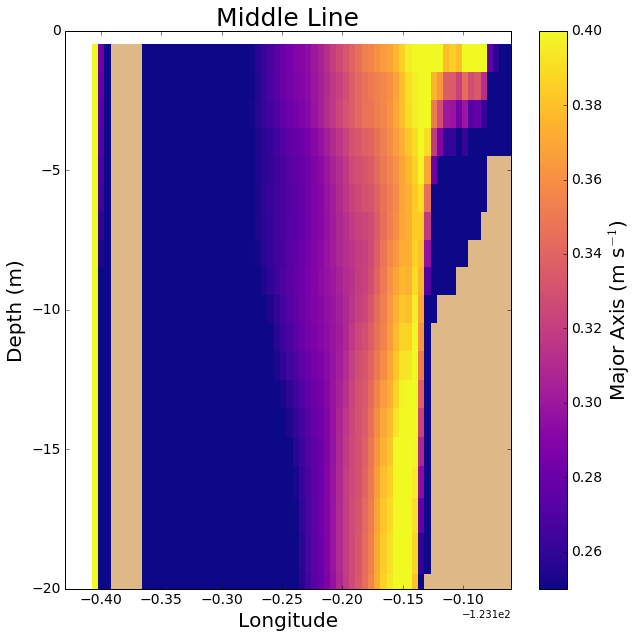

In [378]:
m = major == 0
major_masked = np.ma.array(major,mask=m)
fig, ax =plt.subplots(1,1,figsize=(10,10))
cmap = plt.get_cmap('plasma')
cmap.set_bad('burlywood')
mesh=ax.pcolormesh(lon[27], -depths[:], major_masked[27].transpose(), cmap=cmap, vmax=0.4, vmin=0.25)
ax.set_ylim((-20,0))
ax.set_xlim(-123.53, -123.16)
#ax.set_xlim(-123.45, -123.09)
#ax.set_xticks((-123.4, -123.3, -123.2, -123.1))
#ax.set_xticklabels(('-123.4','-123.3', '-123.2', '-123.1'))
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Depth (m)", fontsize=20)
cbar = fig.colorbar(mesh)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Major Axis (m s$^{-1}$)", fontsize=20)
ax.set_title("Middle Line", fontsize=25)

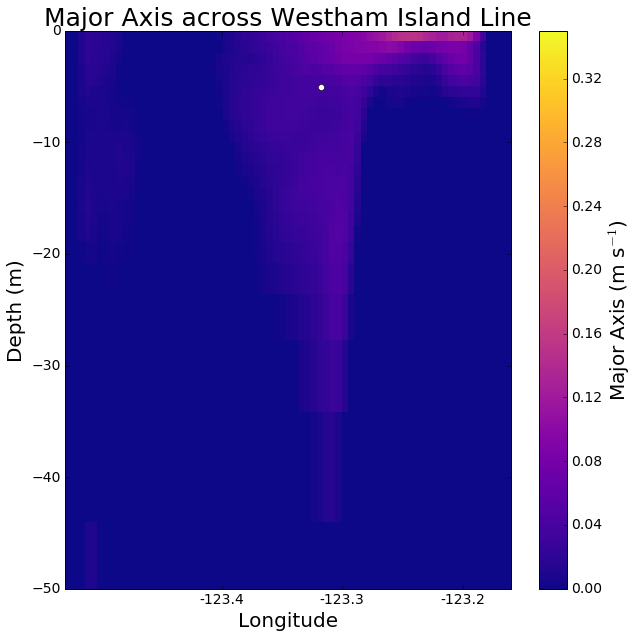

In [499]:
m = major == 0
major_masked = np.ma.array(major,mask=m)
fig, ax =plt.subplots(1,1,figsize=(10,10))
cmap = plt.get_cmap('plasma')
cmap.set_bad('burlywood')
mesh=ax.pcolormesh(lon[35], -depths[:]+0.5, CX[35].transpose(), cmap=cmap, vmax=0.35, vmin=0.)
ax.set_ylim((-50,0))
ax.set_xlim(-123.53, -123.16)
ax.set_xticks((-123.4, -123.3, -123.2))
ax.set_xticklabels(('-123.4','-123.3', '-123.2'))
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Depth (m)", fontsize=20)
cbar = fig.colorbar(mesh)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Major Axis (m s$^{-1}$)", fontsize=20)
ax.set_title("Major Axis across Westham Island Line", fontsize=25)
ax.plot(east_lon,-5,'wo')

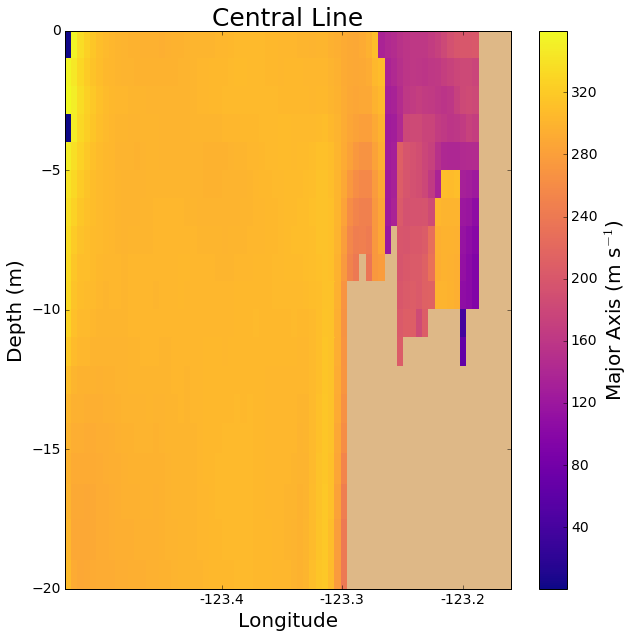

In [429]:
m = major == 0
major_masked = np.ma.array(major,mask=m)
p = phase == 0
phase_masked = np.ma.array(phase,mask=p)
fig, ax =plt.subplots(1,1,figsize=(10,10))
cmap = plt.get_cmap('plasma')
cmap.set_bad('burlywood')
mesh=ax.pcolormesh(lon[icent], -depths[:]+0.5, phase_masked[icent].transpose(), cmap=cmap)
ax.set_ylim((-20,0))
ax.set_xlim(-123.53, -123.16)
ax.set_xticks((-123.4, -123.3, -123.2))
ax.set_xticklabels(('-123.4','-123.3', '-123.2'))
for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
ax.set_xlabel("Longitude", fontsize=20)
ax.set_ylabel("Depth (m)", fontsize=20)
cbar = fig.colorbar(mesh)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label("Major Axis (m s$^{-1}$)", fontsize=20)
ax.set_title("Central Line", fontsize=25)

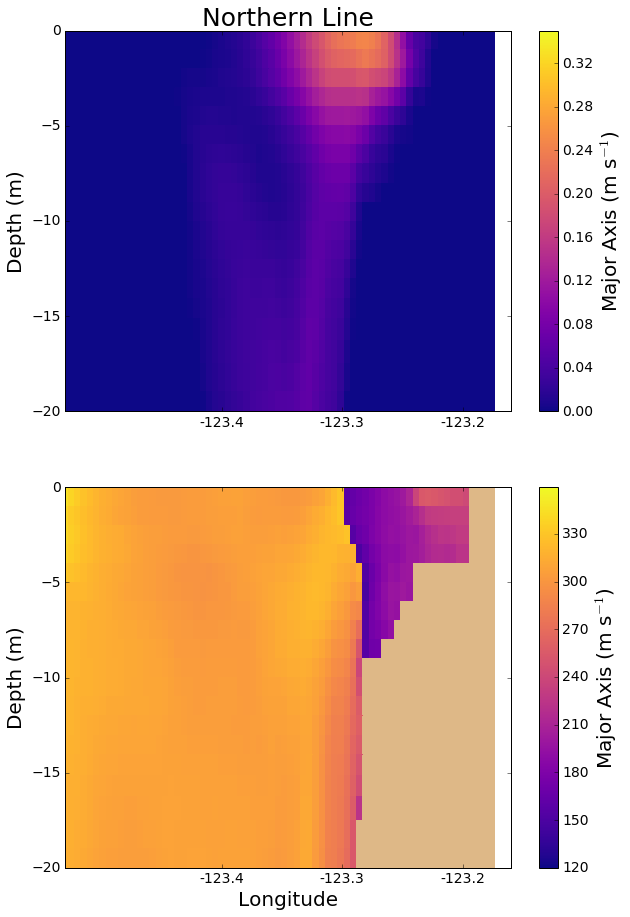

In [497]:
m = major == 0
major_masked = np.ma.array(major,mask=m)
p = phase == 0
phase_masked = np.ma.array(phase,mask=p)
fig, ax =plt.subplots(2,1,figsize=(10,15))
cmap = plt.get_cmap('plasma')
cmap.set_bad('burlywood')

for ia in [0,1]:
    if ia==0:
        mesh=ax[0].pcolormesh(lon[50], -depths[:]+0.5, CX[50].transpose(), cmap=cmap, vmax=0.35, vmin=0)
    else:
        mesh=ax[1].pcolormesh(lon[50], -depths[:]+0.5, phase_masked[50].transpose(), cmap=cmap, vmin=120)

    ax[ia].set_ylim((-20,0))
    ax[ia].set_xlim(-123.53, -123.16)
    ax[ia].set_xticks((-123.4, -123.3, -123.2))
    ax[ia].set_xticklabels(('-123.4','-123.3', '-123.2'))
    axe = ax[ia]
    for tick in axe.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    for tick in axe.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    ax[1].set_xlabel("Longitude", fontsize=20)
    ax[ia].set_ylabel("Depth (m)", fontsize=20)
    cbar = fig.colorbar(mesh, ax=ax[ia])
    cbar.ax.tick_params(labelsize=14) 
    cbar.set_label("Major Axis (m s$^{-1}$)", fontsize=20)
ax[0].set_title("Northern Line", fontsize=25)

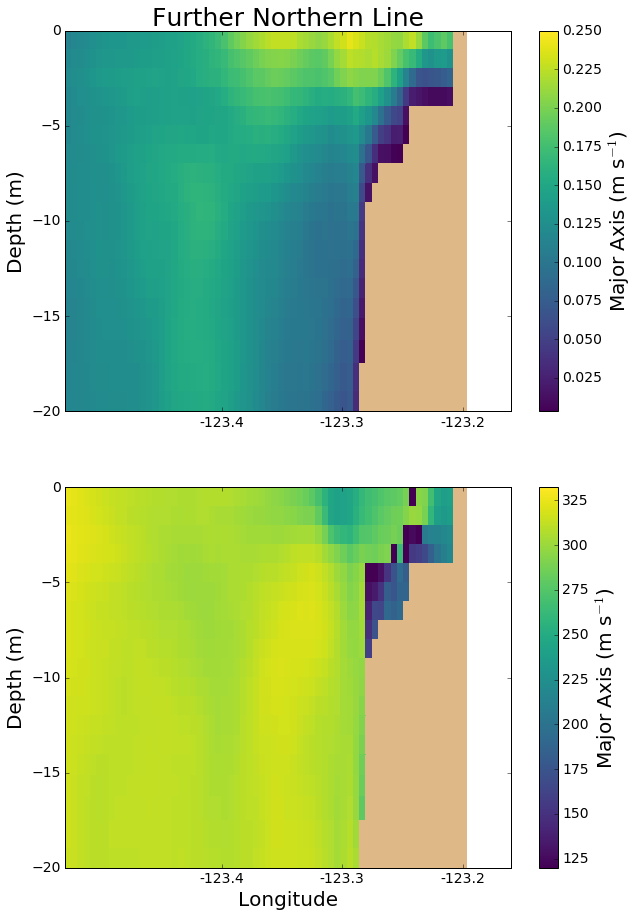

In [417]:
m = major == 0
major_masked = np.ma.array(major,mask=m)
p = phase == 0
phase_masked = np.ma.array(phase,mask=p)
fig, ax =plt.subplots(2,1,figsize=(10,15))
cmap = plt.get_cmap('viridis')
cmap.set_bad('burlywood')

for ia in [0,1]:
    if ia==0:
        mesh=ax[0].pcolormesh(lon[57], -depths[:]+0.5, major_masked[57].transpose(), cmap=cmap, vmax=0.25)
    else:
        mesh=ax[1].pcolormesh(lon[57], -depths[:]+0.5, phase_masked[57].transpose(), cmap=cmap, vmin=120)

    ax[ia].set_ylim((-20,0))
    ax[ia].set_xlim(-123.53, -123.16)
    ax[ia].set_xticks((-123.4, -123.3, -123.2))
    ax[ia].set_xticklabels(('-123.4','-123.3', '-123.2'))
    axe = ax[ia]
    for tick in axe.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    for tick in axe.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    ax[1].set_xlabel("Longitude", fontsize=20)
    ax[ia].set_ylabel("Depth (m)", fontsize=20)
    cbar = fig.colorbar(mesh, ax=ax[ia])
    cbar.ax.tick_params(labelsize=14) 
    cbar.set_label("Major Axis (m s$^{-1}$)", fontsize=20)
ax[0].set_title("Further Northern Line", fontsize=25)

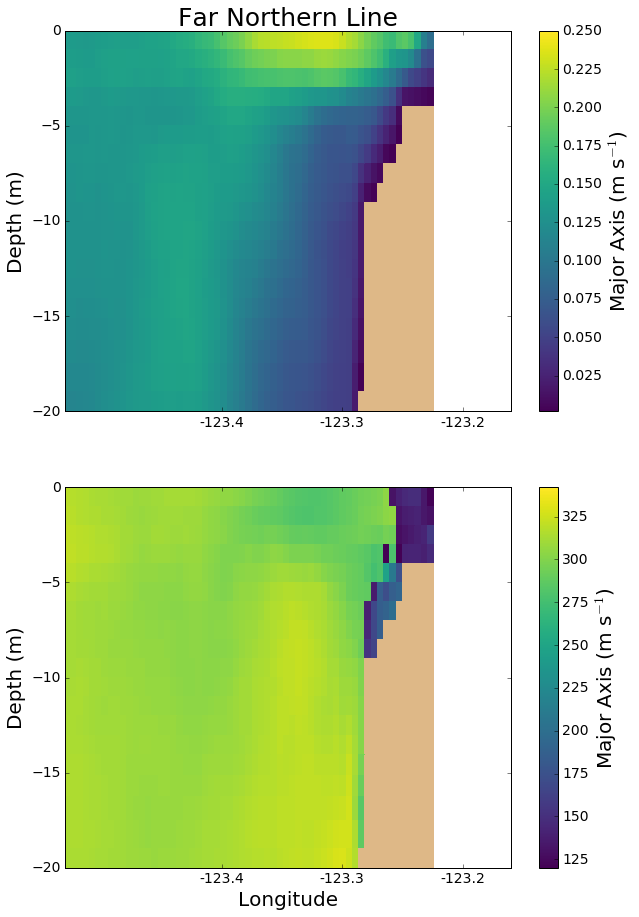

In [420]:
m = major == 0
major_masked = np.ma.array(major,mask=m)
p = phase == 0
phase_masked = np.ma.array(phase,mask=p)
fig, ax =plt.subplots(2,1,figsize=(10,15))
cmap = plt.get_cmap('viridis')
cmap.set_bad('burlywood')

for ia in [0,1]:
    if ia==0:
        mesh=ax[0].pcolormesh(lon[65], -depths[:]+0.5, major_masked[65].transpose(), cmap=cmap, vmax=0.25)
    else:
        mesh=ax[1].pcolormesh(lon[65], -depths[:]+0.5, phase_masked[65].transpose(), cmap=cmap, vmin=120)

    ax[ia].set_ylim((-20,0))
    ax[ia].set_xlim(-123.53, -123.16)
    ax[ia].set_xticks((-123.4, -123.3, -123.2))
    ax[ia].set_xticklabels(('-123.4','-123.3', '-123.2'))
    axe = ax[ia]
    for tick in axe.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    for tick in axe.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    ax[1].set_xlabel("Longitude", fontsize=20)
    ax[ia].set_ylabel("Depth (m)", fontsize=20)
    cbar = fig.colorbar(mesh, ax=ax[ia])
    cbar.ax.tick_params(labelsize=14) 
    cbar.set_label("Major Axis (m s$^{-1}$)", fontsize=20)
ax[0].set_title("Far Northern Line", fontsize=25)

In [501]:
print (depths[21])
base_CX, base_SX, base_CY, base_SY, base_ap, base_am, base_ep, base_em, base_major, base_minor, base_theta, base_phase, base_u_M2amp, base_u_M2pha, base_v_M2amp, base_v_M2pha = (
CX, SX, CY, SY, ap, am, ep, em, major, minor, theta, phase, u_M2amp, u_M2pha, v_M2amp, v_M2pha)


28.2299


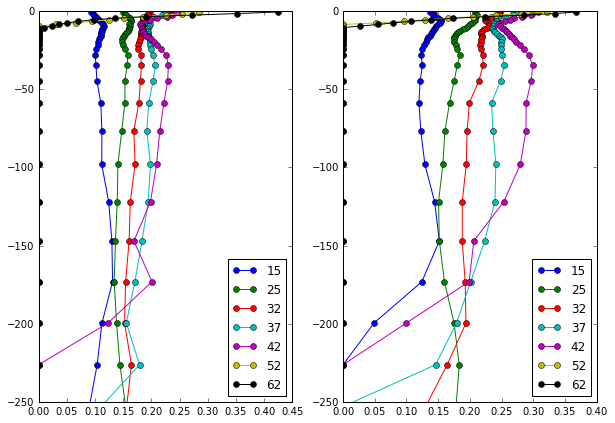

In [135]:
fig, axs = plt.subplots(1,2,figsize=(10,7))
for ii in [43]:
    for jj in jjchoice:
        axs[0].plot(major[ii, jj], -depths[:], 'o-', label=jj)
axs[0].set_ylim(-250,0)
axs[0].legend(loc='lower right')
for ii in [35]:
    for jj in jjchoice:
        axs[1].plot(major[ii, jj], -depths[:], 'o-', label=jj)
axs[1].set_ylim(-250,0)
axs[1].legend(loc='lower right')

In [520]:
eastobs = np.loadtxt('/ocean/mhalvers/research/adcp/east_ADCP_M2_ellipse_params.txt', skiprows=2, unpack=True)
central = np.loadtxt('/ocean/mhalvers/research/adcp/central_ADCP_M2_ellipse_params.txt', skiprows=2, unpack=True)

In [558]:
codar = [[0.113, 0.008, 126, 273,0.074, 0.006, 134, 131],[0.138, -0.037, 134, 282, 0.077, -0.009, 129, 187]]

In [529]:
to = datetime.datetime(2014,11,26)
tf = datetime.datetime(2015, 7, 13)

t_o = to.strftime('%d%b%y').lower()
t_f = tf.strftime('%d%b%y').lower()

runname1 = '{}_{}_Central'.format(t_o, t_f)
runname2 = '{}_{}_East'.format(t_o, t_f)


cols=np.arange(0,9)

df1 = pd.read_csv('/ocean/nsoontie/MEOPAR/TidalEllipseData/Nodes/'+runname1+'.csv', usecols=cols) 
df2 = pd.read_csv('/ocean/nsoontie/MEOPAR/TidalEllipseData/Nodes/'+runname2+'.csv', usecols=cols)

cen = df1.as_matrix()
east = df2.as_matrix()

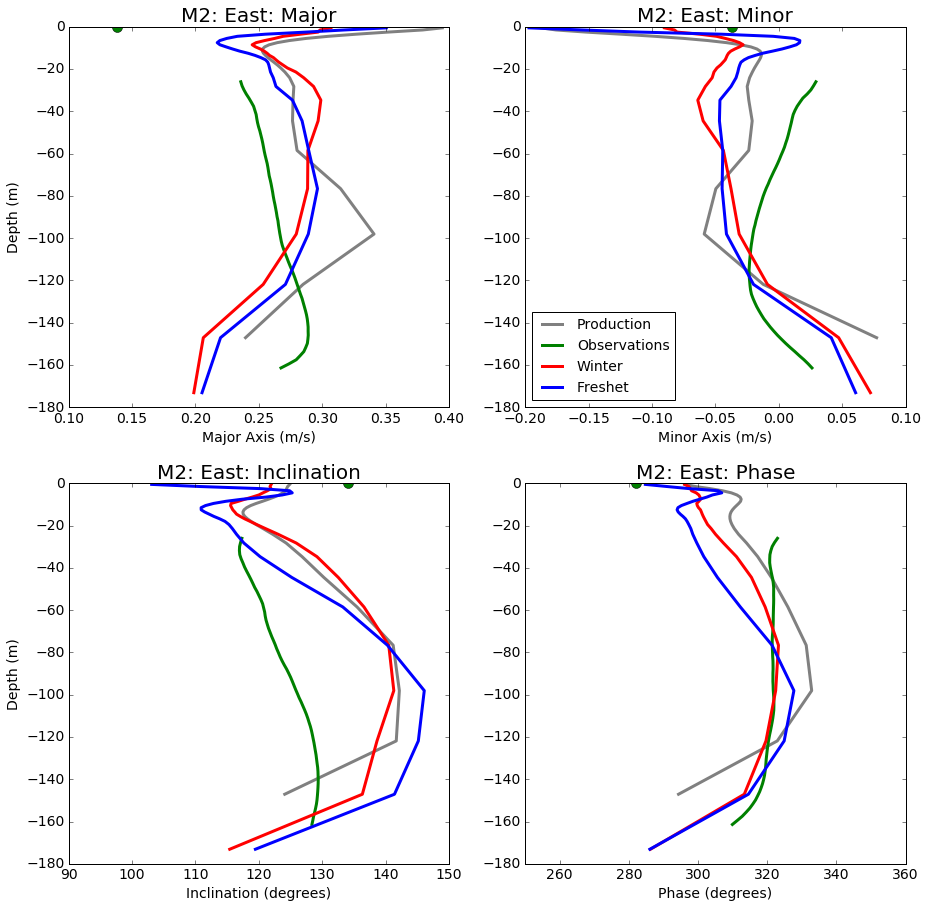

In [577]:
fig, axs = plt.subplots(2,2,figsize=(15,15))
axs[0,0].plot(east[:-10,1],-east[:-10,0], color='grey', linewidth=3)
axs[0,0].plot(eastobs[1]/100., -eastobs[0], 'g', linewidth=3)
axs[0,0].plot(codar[1][0],0, 'go', markersize=10)
axs[0,0].plot(base_major[ieast, jeast, :30], -depths[:30], 'r', linewidth=3)
axs[0,0].plot(major[ieast, jeast, :30], -depths[:30], 'b', linewidth=3)
axs[0,0].set_xlim((0.1,0.4))
axs[0,0].set_title("M2: East: Major", fontsize=20)
axs[0,1].plot(east[:-10,2],-east[:-10,0], color='grey', label='Production', linewidth=3)
axs[0,1].plot(eastobs[2]/100., -eastobs[0], 'g', label='Observations', linewidth=3)
axs[0,1].plot(codar[1][1],0, 'go', markersize=10)
axs[0,1].plot(base_minor[ieast, jeast, :30], -depths[:30], 'r', label='Winter', linewidth=3)
axs[0,1].plot(minor[ieast, jeast, :30], -depths[:30], 'b', label='Freshet', linewidth=3)
axs[0,1].legend(loc='lower left', fontsize=14)
axs[0,1].set_xlim((-0.2,0.1))
axs[0,1].set_title("M2: East: Minor", fontsize=20)
axs[1,0].plot(east[:-10,3],-east[:-10,0], color='grey', linewidth=3)
axs[1,0].plot(eastobs[3], -eastobs[0], 'g', linewidth=3)
axs[1,0].plot(codar[1][2],0, 'go', markersize=10)
axs[1,0].plot(base_theta[ieast, jeast, :30]+29, -depths[:30], 'r', linewidth=3)
axs[1,0].plot(theta[ieast, jeast, :30]+29, -depths[:30],'b', linewidth=3)
axs[1,0].set_xlim((90,150))
axs[1,0].set_title("M2: East: Inclination", fontsize=20)
axs[1,1].plot(east[:-10,4],-east[:-10,0], color='grey', linewidth=3)
axs[1,1].plot(eastobs[4], -eastobs[0], 'g', linewidth=3)
axs[1,1].plot(codar[1][3],0, 'go', markersize=10)
axs[1,1].plot(base_phase[ieast, jeast, :30], -depths[:30], 'r', linewidth=3)
axs[1,1].plot(phase[ieast, jeast, :30], -depths[:30], 'b', linewidth=3)
axs[1,1].set_xlim((250,360))
axs[1,1].set_title("M2: East: Phase", fontsize=20)
axs[0,0].set_ylabel('Depth (m)', fontsize=14)
axs[1,0].set_ylabel("Depth (m)", fontsize=14)
for axe in (axs[0,0], axs[0,1], axs[1,0], axs[1,1]):
    for tick in axe.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    for tick in axe.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
axs[0,0].set_xlabel("Major Axis (m/s)", fontsize=14)
axs[0,1].set_xlabel("Minor Axis (m/s)", fontsize=14)
axs[1,0].set_xlabel("Inclination (degrees)", fontsize=14)
axs[1,1].set_xlabel("Phase (degrees)", fontsize=14)


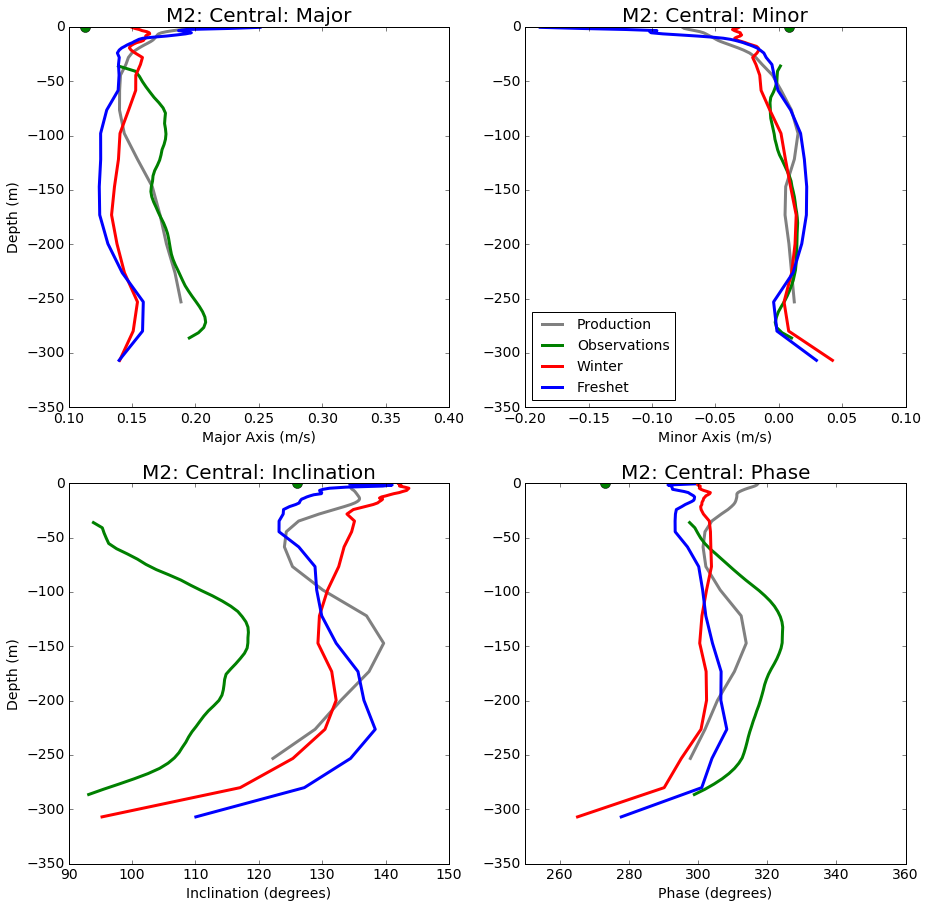

In [578]:
fig, axs = plt.subplots(2,2,figsize=(15,15))
axs[0,0].plot(cen[:-6,1],-cen[:-6,0], color='grey', linewidth=3)
axs[0,0].plot(central[1]/100., -central[0], 'g', linewidth=3)
axs[0,0].plot(codar[0][0],0, 'go', markersize=10)
axs[0,0].plot(base_major[icent, jcent, :35], -depths[:35], 'r', linewidth=3)
axs[0,0].plot(major[icent, jcent, :35], -depths[:35], 'b', linewidth=3)
axs[0,0].set_xlim((0.1,0.4))
axs[0,0].set_title("M2: Central: Major", fontsize=20)
axs[0,1].plot(cen[:-6,2],-cen[:-6,0], color='grey', label='Production', linewidth=3)
axs[0,1].plot(central[2]/100., -central[0], 'g', label='Observations', linewidth=3)
axs[0,1].plot(codar[0][1],0, 'go', markersize=10)
axs[0,1].plot(base_minor[icent, jcent, :35], -depths[:35], 'r', label='Winter', linewidth=3)
axs[0,1].plot(minor[icent, jcent, :35], -depths[:35], 'b', label='Freshet', linewidth=3)
axs[0,1].legend(loc='lower left', fontsize=14)
axs[0,1].set_xlim((-0.2,0.1))
axs[0,1].set_title("M2: Central: Minor", fontsize=20)
axs[1,0].plot(cen[:-6,3],-cen[:-6,0], color='grey', linewidth=3)
axs[1,0].plot(central[3], -central[0], 'g', linewidth=3)
axs[1,0].plot(codar[0][2],0, 'go', markersize=10)
axs[1,0].plot(base_theta[icent, jcent, :35]+29, -depths[:35], 'r', linewidth=3)
axs[1,0].plot(theta[icent, jcent, :35]+29, -depths[:35],'b', linewidth=3)
axs[1,0].set_xlim((90,150))
axs[1,0].set_title("M2: Central: Inclination", fontsize=20)
axs[1,1].plot(cen[:-6,4],-cen[:-6,0], color='grey', linewidth=3)
axs[1,1].plot(central[4], -central[0], 'g', linewidth=3)
axs[1,1].plot(codar[0][3],0, 'go', markersize=10)
axs[1,1].plot(base_phase[icent, jcent, :35], -depths[:35], 'r', linewidth=3)
axs[1,1].plot(phase[icent, jcent, :35], -depths[:35], 'b', linewidth=3)
axs[1,1].set_xlim((250,360))
axs[1,1].set_title("M2: Central: Phase", fontsize=20)
axs[0,0].set_ylabel('Depth (m)', fontsize=14)
axs[1,0].set_ylabel("Depth (m)", fontsize=14)
for axe in (axs[0,0], axs[0,1], axs[1,0], axs[1,1]):
    for tick in axe.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)
    for tick in axe.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)
axs[0,0].set_xlabel("Major Axis (m/s)", fontsize=14)
axs[0,1].set_xlabel("Minor Axis (m/s)", fontsize=14)
axs[1,0].set_xlabel("Inclination (degrees)", fontsize=14)
axs[1,1].set_xlabel("Phase (degrees)", fontsize=14)
